In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
# from torchvision.transforms import 
from tqdm import tqdm


In [3]:
batch_size = 12

#### Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((50,50)),
    transforms.Lambda(lambda t : (t*2)-1)
    ])

In [5]:
training_data = datasets.Flowers102(
    root="data",
    split='train',
    download=True,
    transform=transform
)
validation_data = datasets.Flowers102(
    root="data",
    split='val',
    download=True,
    transform=transform
)

test_data =  datasets.Flowers102(
    root="data",
    split='test',
    download=True,
    transform=transform
)

In [6]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [7]:
def show_image(img):
    # print("Shape of img [C, H, W]: ", img.shape)
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t : (t+1)/2),
        transforms.Lambda(lambda t : t.permute(1,2,0)), # Convert from CHW to HWC
        transforms.Lambda(lambda t : t*255.),
        transforms.Lambda(lambda t : t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
        ])
    # print("After transform: Shape of img [C, H, W]: ", reverse_transform(img).shape)
    plt.imshow(reverse_transform(img))

In [8]:
loader_iter =iter(test_dataloader)

Shape of X [N, C, H, W]:  torch.Size([12, 3, 50, 50])


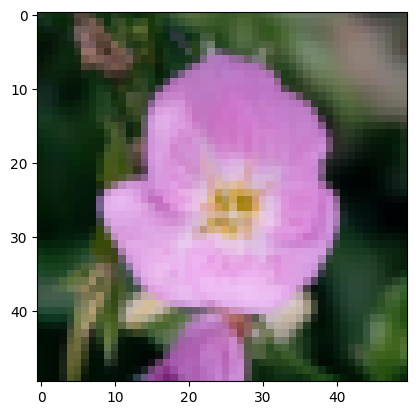

In [9]:
for X in next(loader_iter):
    print("Shape of X [N, C, H, W]: ", X.shape) 
    show_image(X[0])
    break

#### Formward diff

In [32]:
# Noise Scheduler
def noise_scheduler(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def get_value_at_timestep(values, t, x0_shape):
    batch_size = t.shape[0]
    values_at_t = values.gather(-1,t) 
    values = values_at_t.reshape(batch_size,*(-1)*x0_shape) 
    return values

# Forward diffusion
def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    sqrt_alphas_cumprod_t = get_value_at_timestep(sqrt_alphas_cumprod, t, x0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_value_at_timestep(
        sqrt_one_minus_alphas_cumprod, t, x0.shape
    ) 
    diffused_image = sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise
    return diffused_image, noise
    
# Pre calucalte values for forward diffusion
T = 100
betas = noise_scheduler(T)
# print(betas)
alphas = 1 - betas
# print(alphas)
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = torch.cat([torch.ones(1),alphas_cumprod[:-1]],dim=0) # [1.0] +alphas_cumprod[:-1]
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [19]:
test_image = next(iter(train_dataloader))[0][0] # first img in first batch of train_dataloader

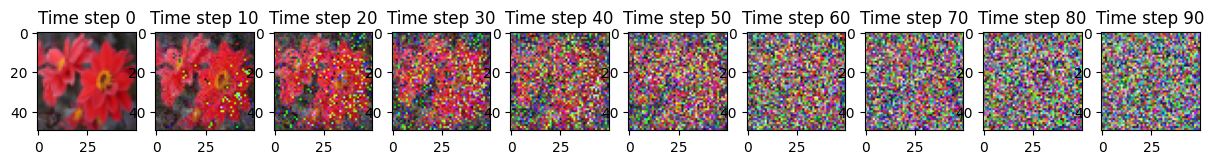

In [33]:
step_size = T//10
plt.figure(figsize=(15,15))
num_images = 10 # T/step_size
for i in range(0,T,step_size):
    t = torch.tensor([i])
    # print(t.shape)
    # print(t)
    diffused_image,noise = forward_diffusion(test_image, t)
    plt.subplot(1, num_images, int(i/step_size) + 1)
    plt.title(f'Time step {i}', fontsize=12)
    show_image(diffused_image)

#### Reverse 

##### U-net block

In [21]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        print('Channels:',in_channels, out_channels)    
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        return self.activation(self.conv2(self.activation(self.conv1(x))))

In [22]:
block = Block(3, 64)
x = torch.randn(3,64,64)
block(x).shape

Channels: 3 64


torch.Size([64, 64, 64])

##### Encoder

In [23]:
class Encoder(nn.Module):
    def __init__(self, channels = [3, 64, 128, 256, 512, 1024]):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(channels[i], channels[i+1])  
                                         for i in range(len(channels)-1)
                                         ])
        self.maxpool = nn.MaxPool2d(2)
        
    def forward(self, x):
        features = []
        for block in self.enc_blocks:
            x = block(x)
            features.append(x)
            x = self.maxpool(x)
            print(x.shape)
        return features

In [24]:
encoder = Encoder()

Channels: 3 64
Channels: 64 128
Channels: 128 256
Channels: 256 512
Channels: 512 1024


In [25]:
residuals = encoder(x)

torch.Size([64, 32, 32])
torch.Size([128, 16, 16])
torch.Size([256, 8, 8])
torch.Size([512, 4, 4])
torch.Size([1024, 2, 2])


In [26]:
print(residuals)

[tensor([[[0.0280, 0.0000, 0.0094,  ..., 0.0229, 0.0436, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1558, 0.0000],
         [0.0193, 0.1782, 0.0000,  ..., 0.0000, 0.1620, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1333, 0.0437, 0.0000],
         [0.0585, 0.0000, 0.0596,  ..., 0.0758, 0.0000, 0.0935],
         [0.0000, 0.0000, 0.0000,  ..., 0.1246, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0911, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0935, 0.0000],
         ...,
         [0.0000, 0.0000, 0.2067,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0935, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0745, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1816, 0.0738, 0.0424],
         [0.0458, 0.1836, 0.0239,  ..., 0.0970, 0.0595, 0

##### Decoder

In [27]:
class Decoder(nn.Module):
    def __init__(self, channels = [1024, 512, 256, 128, 64]):
        super().__init__()
        self.dec_blocks = nn.ModuleList([Block(channels[i], channels[i+1])
                                         for i in range(len(channels)-1)])
        self.output = nn.Conv2d(channels[-1], 3, 1)
    def forward(self, x):
        for block in self.dec_blocks:
            x = block(x)
            print(x.shape)
            # Predict noise
            x = self.output(x)
            print('Output:',x.shape)
            return x
        

In [28]:
class DDPM(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

#### Training

In [31]:
num_epochs = 10
loss = nn.L1Loss()
model = DDPM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Channels: 3 64
Channels: 64 128
Channels: 128 256
Channels: 256 512
Channels: 512 1024
Channels: 1024 512
Channels: 512 256
Channels: 256 128
Channels: 128 64


In [ ]:
step_size = 1
plt.figure(figsize=(15,15))
num_images = num_epochs # T/step_size
for epoch in tqdm(num_epochs):
    for x in train_dataloader:
        optimizer.zero_grad()
        diffused_image,noise = forward_diffusion(test_image, t)
        t = torch.randint(0, T, (batch_size,))
        # t = torch.randint(0,T, (x.shape[0],))
        noise = torch.randn_like(x)
        noise = model(t, noise, model)
        x0 = model(x)
        loss = (noise - x0)**2

In [ ]:

for i in range(0,T,step_size):
    t = torch.tensor([i])
    # print(t.shape)
    # print(t)
    diffused_image,noise = forward_diffusion(test_image, t)
    plt.subplot(1, num_images, int(i/step_size) + 1)
    plt.title(f'Time step {i}', fontsize=12)
    show_image(diffused_image)